In [1]:
# !pip install -U -q antspyx
# !pip install -U -q SimpleITK
# !pip install -U -q tqdm
# !pip install -U -q psutil
# !pip install -U -q tensorflow_addons

In [2]:
import json
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['TF_CPP_MIN_VLOG_LEVEL'] = '3'
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

from runtime import RunTime

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-3h0sdlek because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Quadro RTX 8000, compute capability 7.5


In [3]:
base_model_name = 'brats2020_unet_se'
model_dir = '/tf/data/brats_2020/models/pocketnet/unet_se'
prediction_dir = '/tf/data/brats_2020/predictions/pocketnet/unet_se'
results_csv = '/tf/github/MIST/mist/results/brats2020_unet_se_results.csv'
user_params_json_file = os.path.join('/tf/github/MIST/mist/user_params', 
                                     'brats2020_unet_se_user_params.json')


user_params = {'raw_data_dir': '/tf/data/brats_2020/raw/train',
               'processed_data_dir': '/tf/data/brats_2020/processed/tfrecord',
               'base_model_name': base_model_name,
               'model_dir': model_dir,
               'prediction_dir': prediction_dir,
               'raw_paths_csv': '/tf/github/MIST/mist/path_csv/brats2020_paths.csv',
               'inferred_params': '/tf/github/MIST/mist/inferred_params/brats2020_inferred_params.json',
               'results_csv': results_csv,
               'modality': 'mr',
               'mask': ['seg_binary.nii.gz'], 
               'images': {'t1': ['t1.nii.gz'], 
                          't2': ['t2.nii.gz'], 
                          'tc': ['t1ce.nii.gz'], 
                          'fl': ['flair.nii.gz']}, 
               'labels': [0, 1],
               'final_classes': {'WT': [1]},
               'loss': 'dice', 
               'model': 'unet-se', 
               'pocket': False, 
               'ablation_level': 5} 


with open(user_params_json_file, 'w') as outfile: 
    json.dump(user_params, outfile)

train = RunTime(user_params_json_file)
train.run(run_preprocess = False)

Starting split 1/5
Epoch 1/125
250/250 [==============================] - 110s 379ms/step - loss: 0.2324
INFO:tensorflow:Assets written to: /tf/data/brats_2020/models/pocketnet/unet_se/brats2020_unet_se_current_model_split_1/assets
Val loss of DID NOT improve from inf
Epoch 2/125
250/250 [==============================] - 105s 381ms/step - loss: 0.1952
INFO:tensorflow:Assets written to: /tf/data/brats_2020/models/pocketnet/unet_se/brats2020_unet_se_current_model_split_1/assets
Val loss of DID NOT improve from inf
Epoch 3/125
250/250 [==============================] - 105s 379ms/step - loss: 0.1846
INFO:tensorflow:Assets written to: /tf/data/brats_2020/models/pocketnet/unet_se/brats2020_unet_se_current_model_split_1/assets
Val loss IMPROVED from inf to 0.09327426552772522
INFO:tensorflow:Assets written to: /tf/data/brats_2020/models/pocketnet/unet_se/brats2020_unet_se_best_model_split_1/assets
Epoch 4/125
250/250 [==============================] - 105s 378ms/step - loss: 0.1783
INFO:ten

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, metrics, mixed_precision
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K

from loss import *

import pandas as pd
import numpy as np
import ants
import os
import pdb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import json

os.environ['CUDA_VISIBLE_DEVICES'] = '6'

user_params = os.path.join('/tf/github/MIST/mist/user_params', 
                           'brats2020_full_unet_user_params.json')

# Get GPUs
gpus = tf.config.list_physical_devices('GPU')

# For tensorflow 2.x.x allow memory growth on GPU
###################################
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
###################################

def decode_val(serialized_example):
    features_dict = {'image': tf.io.VarLenFeature(tf.float32),
                     'mask': tf.io.VarLenFeature(tf.float32),
                     'dims': tf.io.FixedLenFeature([3], tf.int64),
                     'num_channels': tf.io.FixedLenFeature([1], tf.int64), 
                     'num_classes': tf.io.FixedLenFeature([1], tf.int64), 
                     'label_points': tf.io.VarLenFeature(tf.int64), 
                     'label_index_ranges': tf.io.FixedLenFeature([3], tf.int64)}

    # Decode examples stored in TFRecord
    features = tf.io.parse_example(serialized_example, features_dict)

    # Extract image/mask pair from sparse tensors
    image = tf.sparse.to_dense(features['image'])
    image = tf.reshape(image, tf.concat([features['dims'], features['num_channels']], axis = -1))

    mask = tf.sparse.to_dense(features['mask'])
    mask = tf.reshape(mask, tf.concat([features['dims'], features['num_classes']], axis = -1))

    return image, mask
    
def val_inference(model, df, ds, mode):
    
        activations = list()
    
        if mode == 'full':
            activations.append(np.zeros((1, 32)))
            activations.append(np.zeros((1, 64)))
            activations.append(np.zeros((1, 128)))
            activations.append(np.zeros((1, 256)))
            activations.append(np.zeros((1, 512)))

            activations.append(np.zeros((1, 1024)))

            activations.append(np.zeros((1, 512)))
            activations.append(np.zeros((1, 256)))
            activations.append(np.zeros((1, 128)))
            activations.append(np.zeros((1, 64)))
            activations.append(np.zeros((1, 32)))
        else:
            activations.append(np.zeros((1, 32)))
            activations.append(np.zeros((1, 32)))
            activations.append(np.zeros((1, 32)))
            activations.append(np.zeros((1, 32)))
            activations.append(np.zeros((1, 32)))

            activations.append(np.zeros((1, 32)))

            activations.append(np.zeros((1, 32)))
            activations.append(np.zeros((1, 32)))
            activations.append(np.zeros((1, 32)))
            activations.append(np.zeros((1, 32)))
            activations.append(np.zeros((1, 32)))
        
        inferred_params_json = os.path.join('/tf/github/MIST/mist/inferred_params', 
                                       'brats2020_inferred_params.json')
        
        with open(inferred_params_json, 'r') as file:
            inferred_params = json.load(file)
        
        iterator = ds.as_numpy_iterator()
        cnt = 0
        patch_cnt = 0
        for element in iterator:
            
            patient = df.iloc[cnt].to_dict()
            image_list = list(patient.values())[2:len(patient)]
            
            original_mask = ants.image_read(patient['mask'])
            original_image = ants.image_read(image_list[0])
            original_dims = ants.image_header_info(image_list[0])['dimensions']
            
            if True:
                nzmask = ants.get_mask(original_image, cleanup = 0)
                original_cropped = ants.crop_image(original_mask, nzmask)
            
            image = element[0]
            truth = element[1]
            dims = image[..., 0].shape
                        
            padding = list()
            cropping = list()
            for i in range(3):
                if dims[i] % inferred_params['patch_size'][i] == 0:
                    padding.append((0, 0))
                    cropping.append((0, dims[i]))
                else:
                    pad_width = int(np.ceil(dims[i] / inferred_params['patch_size'][i]) * inferred_params['patch_size'][i]) - dims[i]
                    padding.append((pad_width // 2, (pad_width // 2) + (pad_width % 2)))
                    cropping.append((pad_width // 2, -1 * ((pad_width // 2) + (pad_width % 2))))
            image = np.pad(image, (*padding, (0, 0)))
            pad_dims = image[..., 0].shape
            
            print('Predicting on {}'.format(patient['id']))
            strides = [patch_dim // 2 for patch_dim in inferred_params['patch_size']]
            for i in range(0, pad_dims[0] - inferred_params['patch_size'][0] + 1, strides[0]):
                for j in range(0, pad_dims[1] - inferred_params['patch_size'][1] + 1, strides[1]):
                    for k in range(0, pad_dims[2] - inferred_params['patch_size'][2] + 1, strides[2]):
                        patch = image[i:(i + inferred_params['patch_size'][0]),
                                      j:(j + inferred_params['patch_size'][1]),
                                      k:(k + inferred_params['patch_size'][2]), ...]
                        patch = patch.reshape((1, *patch.shape))
                        pred_patch = model.predict(patch)
                        for ii in range(len(pred_patch)):
                            activations[ii] += np.mean(pred_patch[ii], axis=tuple(range(pred_patch[ii].ndim - 1)))
                        patch_cnt += 1
            cnt += 1
            
        for ii in range(11):
            activations[ii] /= patch_cnt
            
        return activations
            

# Set up
kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)
df = pd.read_csv('/tf/github/MIST/mist/path_csv/brats2020_paths.csv')
loss = Loss(user_params)

tfrecords = [os.path.join('/tf/data/brats_2020/processed/tfrecord/', 
                          '{}.tfrecord'.format(df.iloc[i]['id'])) for i in range(len(df))]

splits = kfold.split(tfrecords)

splits_train = list()
splits_test = list()
for split in splits:
    splits_train.append(split[0])
    splits_test.append(split[1])
    
folds = [4]
for fold in folds:
    
    # Prepare test set
    test_tfr_list = [tfrecords[idx] for idx in splits_test[fold]]
    test_df_ids = [df.iloc[idx]['id'] for idx in splits_test[fold]]
    test_df = df.loc[df['id'].isin(test_df_ids)].reset_index(drop = True)
    test_ds = tf.data.TFRecordDataset(test_tfr_list, 
                                      compression_type = 'GZIP', 
                                      num_parallel_reads = tf.data.AUTOTUNE)
    test_ds = test_ds.map(decode_val, num_parallel_calls = tf.data.AUTOTUNE)
    
    # Load model
    best_model_name = '/tf/data/brats_2020/models/pocketnet/unet_full/brats2020_full_unet_best_model_split_5'
    model = load_model(best_model_name, custom_objects = {'loss': loss.loss_wrapper(1)})
    
    layer_outputs = [layer.output for layer in [model.layers[6], 
                                                model.layers[13], 
                                                model.layers[20], 
                                                model.layers[27], 
                                                model.layers[34], 
                                                model.layers[41], # <--Bottleneck
                                                model.layers[49], 
                                                model.layers[57], 
                                                model.layers[65], 
                                                model.layers[73], 
                                                model.layers[81]]]
    
    activation_model = Model(inputs = model.input, outputs = layer_outputs)
    
    activations = val_inference(activation_model, test_df, test_ds, 'full')

Predicting on BraTS20_Training_255
Predicting on BraTS20_Training_051
Predicting on BraTS20_Training_201
Predicting on BraTS20_Training_075
Predicting on BraTS20_Training_120
Predicting on BraTS20_Training_257
Predicting on BraTS20_Training_023
Predicting on BraTS20_Training_297
Predicting on BraTS20_Training_360
Predicting on BraTS20_Training_092
Predicting on BraTS20_Training_263
Predicting on BraTS20_Training_361
Predicting on BraTS20_Training_137
Predicting on BraTS20_Training_259
Predicting on BraTS20_Training_087
Predicting on BraTS20_Training_081
Predicting on BraTS20_Training_126
Predicting on BraTS20_Training_298
Predicting on BraTS20_Training_076
Predicting on BraTS20_Training_347
Predicting on BraTS20_Training_224
Predicting on BraTS20_Training_226
Predicting on BraTS20_Training_222
Predicting on BraTS20_Training_247
Predicting on BraTS20_Training_024
Predicting on BraTS20_Training_203
Predicting on BraTS20_Training_335
Predicting on BraTS20_Training_062
Predicting on BraTS2

In [4]:
import matplotlib.pyplot as plt
plt.close('all')
i = range(11)
f = [32, 64, 128, 256, 512, 1024, 512, 256, 128, 64, 32]
#f = [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]
for j in zip(i, f):
    print(j)
    x = range(j[1])
    y = list(activations[j[0]].reshape(j[1],))
    y.sort(reverse = True)
    plt.figure(figsize=(10, 3))
    plt.xlabel('Feature index')
    plt.ylabel('Activation')
    plt.ylim([0, 2])
    plt.bar(x, y, color = (255/255.,127/255.,127/255.,255/255.))
    #plt.bar(x, y, color = (127/255.,127/255.,255/255.,255/255.))
    #plt.show()
    plt.savefig('/tf/github/MIST/mist/figures/full_{}.png'.format(j[0]), bbox_inches = 'tight')

(0, 32)
(1, 64)
(2, 128)
(3, 256)
(4, 512)
(5, 1024)
(6, 512)
(7, 256)
(8, 128)
(9, 64)
(10, 32)


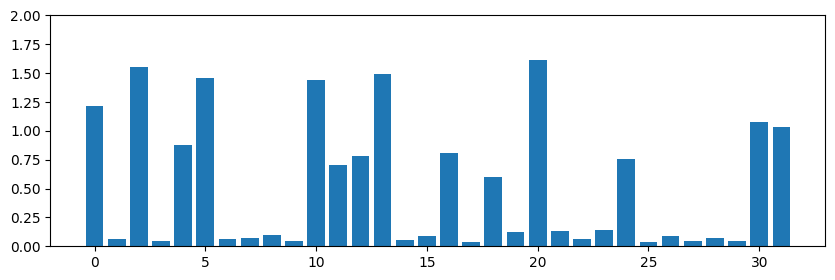

In [128]:
import matplotlib.pyplot as plt
i = 10
f = 32
x = range(f)
y = list(activations[i].reshape(f,))
plt.figure(figsize=(10, 3))
plt.ylim([0, 2])
plt.bar(x, y)
plt.show()

In [324]:
feature = 'encoder4'
np.sum(feature_importance[feature] > np.mean(feature_importance[feature]) + 0.5 * np.std(feature_importance[feature]))

147

In [344]:
model = DenseNet(input_shape = (128, 128, 128), 
             num_channels = 4,
             num_class = 2, 
             init_filters = 32, 
             depth = 5, 
             pocket = True).build_model()

trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
totalParams = trainableParams + nonTrainableParams
 
totalParams

1265730